In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *

import imutils
import cv2
import csv

In [65]:
glob.glob(list_1[1] + '*/')

['/srv/home/chenyu/JDDC/DoseTest/10.0us/10Frames_B3_results/',
 '/srv/home/chenyu/JDDC/DoseTest/10.0us/10Frames_B9_results/',
 '/srv/home/chenyu/JDDC/DoseTest/10.0us/10Frames_B6_results/',
 '/srv/home/chenyu/JDDC/DoseTest/10.0us/10Frames_B7_results/',
 '/srv/home/chenyu/JDDC/DoseTest/10.0us/10Frames_B8_results/',
 '/srv/home/chenyu/JDDC/DoseTest/10.0us/10Frames_B1_results/',
 '/srv/home/chenyu/JDDC/DoseTest/10.0us/10Frames_B4_results/',
 '/srv/home/chenyu/JDDC/DoseTest/10.0us/10Frames_B10_results/',
 '/srv/home/chenyu/JDDC/DoseTest/10.0us/10Frames_B2_results/',
 '/srv/home/chenyu/JDDC/DoseTest/10.0us/10Frames_B5_results/']

In [3]:
threshold_dict = {
    "0.5" : 1.6,
    "1.0" : 3,
    "2.0" : 5,
    "4.0" : 7.5,
    "6.0" : 9,
    "8.0" : 11,
    "10.0" : 13,
    "12.0" : 15
}
# print(dwell_time)
# print(threshold_dict[str(dwell_time)])

In [8]:
path = '/srv/home/chenyu/JDDC/DoseTest/*/'
list_1 = glob.glob(path)
prec_list = np.zeros((len(list_1),2))
prec_std = np.zeros((len(list_1),2))
time_list = np.zeros((len(list_1),1))
for i in range(len(list_1)):
    dwell_time = float(list_1[i].split('/')[-2][:-2])
    time_list[i] = dwell_time
    list_2 = glob.glob(list_1[i] + '*/')
    # generate temporary list to calculate standard deviation
    prec_x_list = []
    prec_y_list = []
    count = 0
    for j in range(len(list_2)):
        path_final = list_2[j]
        csvfile = path_final + 'bump-0_003-centers.csv'
        txtfile = path_final + 'bump-0_003.txt'
        prec = FindPrecision(csvfile, txtfile, threshold_dict[str(dwell_time)], 18)
        if prec[0]<0.3 and prec[1]<0.3:
            prec_list[i,:] = prec_list[i,:] + prec
            prec_x_list.append(prec[0])
            prec_y_list.append(prec[1])
            count = count + 1
    prec_list[i,:] = prec_list[i,:] / count
    prec_std[i,0] = np.std(np.asarray(prec_x_list))
    prec_std[i,1] = np.std(np.asarray(prec_y_list))

In [9]:
prec_std

array([[0.01560942, 0.02295808],
       [0.04477709, 0.01403382],
       [0.03938059, 0.02335867],
       [0.02653449, 0.02292734],
       [0.0424086 , 0.04048019],
       [0.03130732, 0.01259846],
       [0.03688778, 0.02395078],
       [0.03212426, 0.03277877]])

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(0, 0.5, 'Y Precision (pm)')

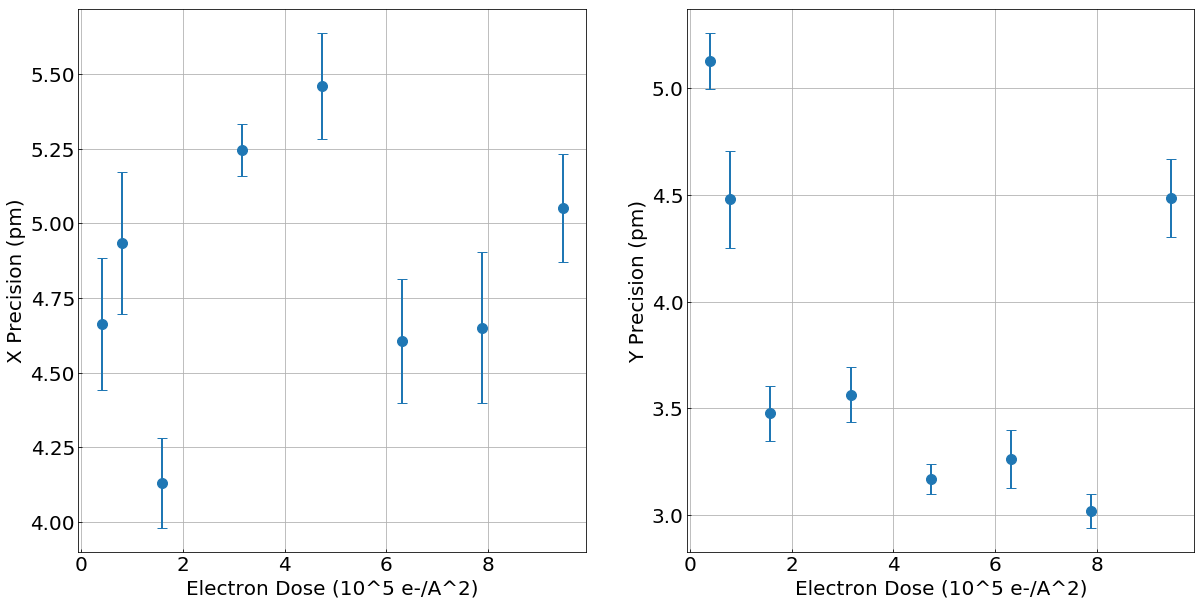

In [10]:
f, axarr = plt.subplots(1,2,figsize=(20,10))

axarr[0].errorbar(time_list*394.5*2*10/10000,prec_list[:,0]*21.8,yerr=prec_std[:,0]*21.8/sqrt(15),fmt='o',label = 'X Precision',capsize=5,
                  markersize = 10,elinewidth = 2)
axarr[0].set_xlabel('Electron Dose (10^5 e-/A^2)',fontsize=20)
axarr[0].tick_params(labelsize=20,direction='in')
axarr[0].grid('on')
axarr[0].set_ylabel('X Precision (pm)', fontsize=20)

axarr[1].errorbar(time_list*394.5*2*10/10000,prec_list[:,1]*21.8,yerr=prec_std[:,1]*21.8/sqrt(15),fmt='o',label = 'X Precision',capsize=5,
                  markersize = 10,elinewidth = 2)
axarr[1].set_xlabel('Electron Dose (10^5 e-/A^2)',fontsize=20)
axarr[1].tick_params(labelsize=20,direction='in')
axarr[1].grid('on')
axarr[1].set_ylabel('Y Precision (pm)', fontsize=20)

# axarr[1].legend(loc='upper right', borderaxespad=0.5,prop={'size': 20})
# axarr[0].legend(loc='upper right', borderaxespad=0.5,prop={'size': 20})

(0.19350157774439145, 0.2554833444278611)


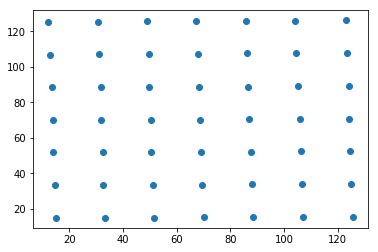

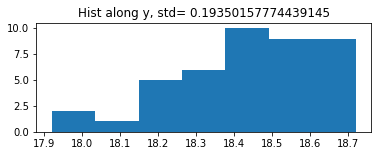

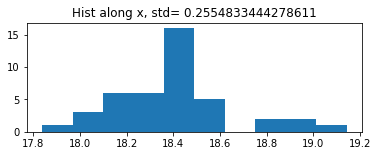

In [62]:
path = '/srv/home/chenyu/JDDC/DoseTest/'
path = '/srv/home/chenyu/JDDC/DoseTest/0.5us/10Frames_B4_results/'
csvfile = path + 'bump-0_003-centers.csv'
txtfile = path + 'bump-0_003.txt'
prec = FindPrecision(csvfile,txtfile,1.5,18)
print(prec)

In [7]:
def FindPrecision(csvFileName,txtFileName,threshold,separation):
    start = 0
    with open(csvFileName) as csvfile:
        file=csv.reader(open(csvFileName,'r'))
        peaks_x = []
        peaks_y = []
        for row in file:
            if start == 0:
                start = 1
                continue
            peaks_x.append(float(row[0]))
            peaks_y.append(float(row[1]))

    with open(txtFileName) as f:
        content = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content];

    peaks_int = []
    for i in range(len(peaks_x)):
        peaks_int.append(float(content[i*3+2]))
        
        
    array_x = np.asarray(peaks_x)
    array_y = np.asarray(peaks_y)
    array_int = np.asarray(peaks_int)
    index = np.where((array_x>10) & (array_x<140) & (array_y > 10) & (array_y < 140))
    array_x = array_x[index]
    array_y = array_y[index]
    array_int = array_int[index]
        
    lattice1 = np.where(array_int>threshold)
    array_x1 = array_x[lattice1]
    array_y1 = array_y[lattice1]
    array_int1 = array_int[lattice1]
    
#     plt.scatter(array_x1,array_y1)

    return FindYStd(array_x1,array_y1,separation),FindXStd(array_x1,array_y1,separation)

In [5]:
def FindYStd(array_x1_copy,array_y1_copy,separation):
    y_sep = []
    while array_x1_copy.size != 0:
        x_cor = array_x1_copy[0]
        index = np.where((array_x1_copy<x_cor+3) & (array_x1_copy>x_cor-3))
        array_y_sub = array_y1_copy[index]
        array_y_sub = np.sort(array_y_sub)
        for i in range(array_y_sub.shape[0]-1):
            spacing = array_y_sub[i+1] - array_y_sub[i]
            if (spacing < separation + 5) & (spacing > separation -5):
                y_sep.append(spacing)
        array_x1_copy = np.delete(array_x1_copy,index)
        array_y1_copy = np.delete(array_y1_copy,index)

    y_std = np.std(np.asarray(y_sep))
#     fig = plt.subplots(figsize=(6,2))
#     plt.hist(y_sep, bins='auto')
#     plt.title('Hist along y, std= '+str(y_std))
    return y_std

In [6]:
def FindXStd(array_x1_copy,array_y1_copy,separation):
    x_sep = []
    while array_x1_copy.size != 0:
        y_cor = array_y1_copy[0]
        index = np.where((array_y1_copy<y_cor+3) & (array_y1_copy>y_cor-3))
        array_x_sub = array_x1_copy[index]
        array_x_sub = np.sort(array_x_sub)
        for i in range(array_x_sub.shape[0]-1):
            spacing = array_x_sub[i+1] - array_x_sub[i]
            if (spacing < separation + 5) & (spacing > separation -5):
                x_sep.append(array_x_sub[i+1] - array_x_sub[i])
        array_x1_copy = np.delete(array_x1_copy,index)
        array_y1_copy = np.delete(array_y1_copy,index)

    x_std = np.std(np.asarray(x_sep))
#     fig = plt.subplots(figsize=(6,2))
#     plt.hist(x_sep, bins='auto')
#     plt.title('Hist along x, std= '+str(x_std))
    return x_std